# AFM Tomography Reconstruction Interactive Notebook

This notebook loads AFM profile images (with an embedded colorbar) from the `AFM_Tomo/data` directory, removes the unwanted colorbar from the right, extracts the central row from each cropped image, and dynamically visualizes the 2D profile stack. A slider lets you select the depth slice to view its 1D AFM profile.

Make sure that your images are named with the depth in microns (e.g. `profile_3um.png`) so that the notebook can sort them correctly.

In [1]:
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import ipywidgets as widgets
from ipywidgets import interactive

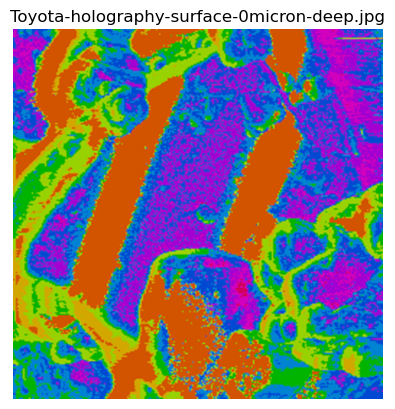

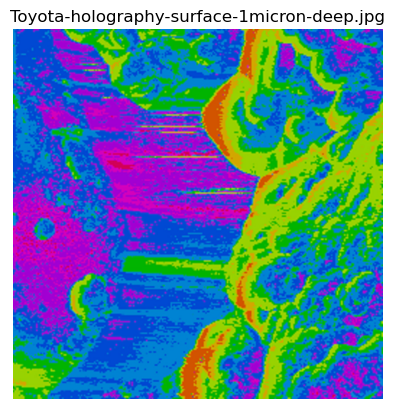

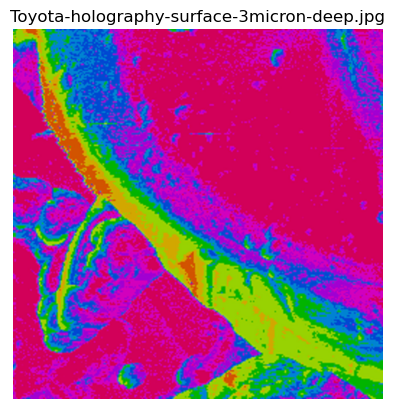

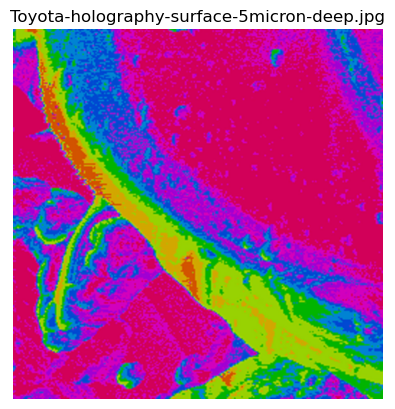

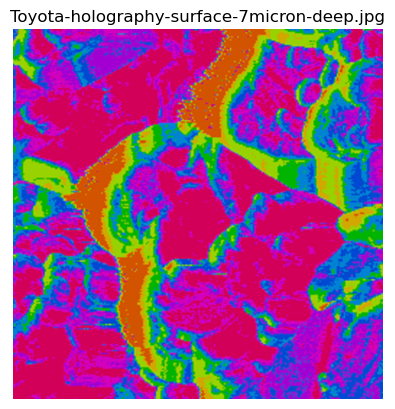

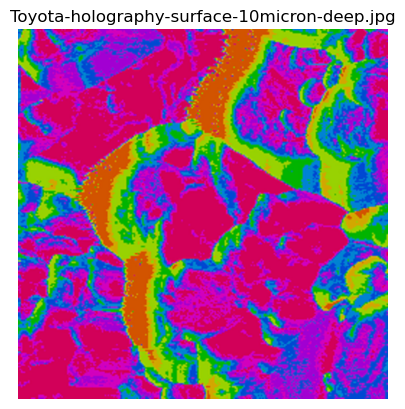

In [6]:
file_list = glob.glob(os.path.join("data", "*.jpg"))
if not file_list:   
    print("No jpg files found in the data folder.")
else:
    # Sort files based on the numerical value in the filename
    sorted_files = sorted(file_list, 
                         key=lambda fp: float(re.findall(r"(\d+\.?\d*)", os.path.basename(fp))[0]))
    
    for filepath in sorted_files:
        img = io.imread(filepath)
        plt.figure()
        plt.imshow(img, cmap='gray')
        plt.title(os.path.basename(filepath))
        plt.axis('off')
        plt.show()

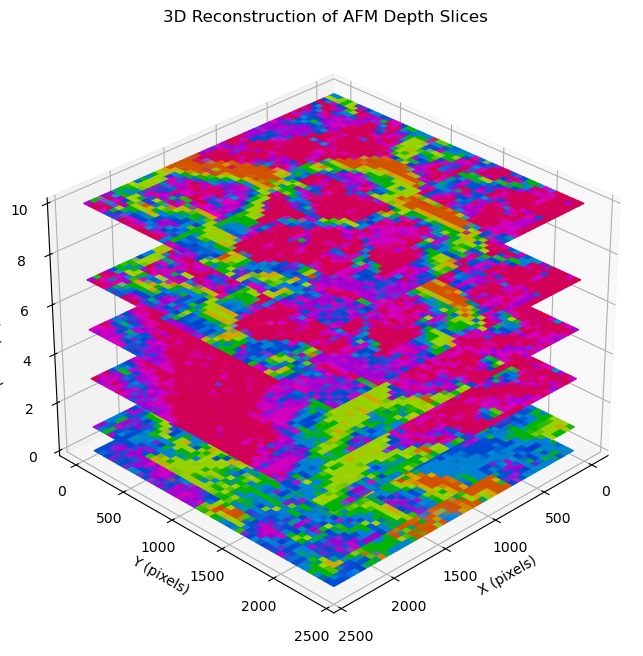

In [8]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# First, let's collect all images and their depths into arrays
images = []
depths = []

for filepath in sorted_files:
    # Extract depth from filename
    depth = float(re.findall(r"(\d+\.?\d*)", os.path.basename(filepath))[0])
    img = io.imread(filepath)
    
    # Normalize image to [0,1] range
    img_normalized = img.astype(float) / 255.0
    
    images.append(img_normalized)
    depths.append(depth)

# Convert to numpy arrays
images = np.array(images)
depths = np.array(depths)

# Create meshgrid for 3D plotting
y, x = np.mgrid[0:images[0].shape[0], 0:images[0].shape[1]]

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each slice
for i, (img, depth) in enumerate(zip(images, depths)):
    stride = 5  # Adjust this value based on your image size
    
    # Create color array for this slice
    colors = np.zeros((x[::stride, ::stride].shape[0], x[::stride, ::stride].shape[1], 4))
    colors[:, :, :3] = img[::stride, ::stride, np.newaxis] if len(img.shape) == 2 else img[::stride, ::stride]
    colors[:, :, 3] = 1.0  # Alpha channel
    
    surf = ax.plot_surface(x[::stride, ::stride],
                          y[::stride, ::stride],
                          np.full_like(x[::stride, ::stride], depth),
                          facecolors=colors,
                          shade=False)

ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
ax.set_zlabel('Depth (microns)')
ax.set_title('3D Reconstruction of AFM Depth Slices')

# Adjust the view angle for better visualization
ax.view_init(elev=30, azim=45)

plt.show()

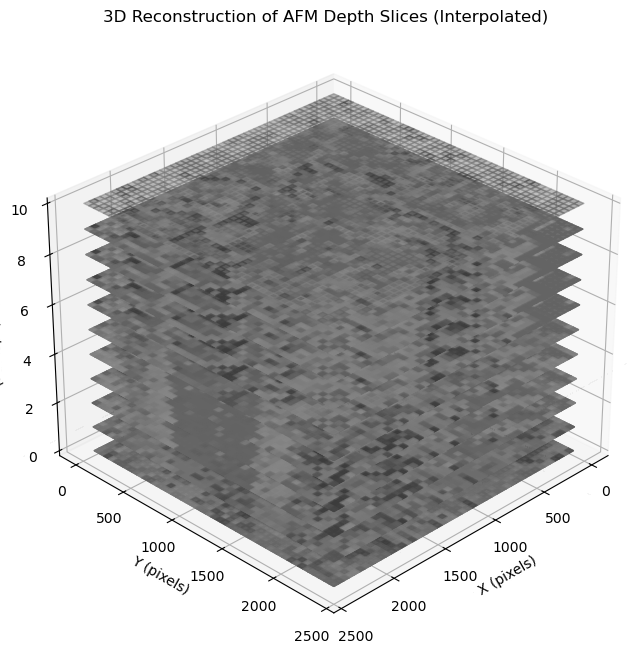

In [10]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp2d

# First, let's collect all images and their depths into arrays
images = []
depths = []

for filepath in sorted_files:
    depth = float(re.findall(r"(\d+\.?\d*)", os.path.basename(filepath))[0])
    img = io.imread(filepath)
    
    # Convert to grayscale if image is RGB
    if len(img.shape) == 3:
        img = np.mean(img, axis=2)  # Convert RGB to grayscale by averaging channels
    
    img_normalized = img.astype(float) / 255.0
    images.append(img_normalized)
    depths.append(depth)

# Convert to numpy arrays
images = np.array(images)
depths = np.array(depths)

# Create a finer depth sampling
num_interpolated_slices = 50  # Adjust this number to control smoothness
depths_interpolated = np.linspace(depths.min(), depths.max(), num_interpolated_slices)

# Now images[0].shape should be 2D
height, width = images[0].shape
interpolated_images = np.zeros((num_interpolated_slices, height, width))

# Create coordinate grids for original image
y_coords = np.arange(height)
x_coords = np.arange(width)

# Interpolate each pixel across depths
for i in range(height):
    for j in range(width):
        pixel_values = images[:, i, j]
        # Create interpolation function for this pixel
        interp_func = np.interp(depths_interpolated, depths, pixel_values)
        interpolated_images[:, i, j] = interp_func

# Create meshgrid for 3D plotting
y, x = np.mgrid[0:height, 0:width]

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each interpolated slice
stride = 5  # Adjust this value based on your image size
for i, (img, depth) in enumerate(zip(interpolated_images, depths_interpolated)):
    colors = np.zeros((x[::stride, ::stride].shape[0], x[::stride, ::stride].shape[1], 4))
    colors[:, :, :3] = img[::stride, ::stride, np.newaxis]
    colors[:, :, 3] = 0.5  # Added some transparency to see through layers
    
    surf = ax.plot_surface(x[::stride, ::stride],
                          y[::stride, ::stride],
                          np.full_like(x[::stride, ::stride], depth),
                          facecolors=colors,
                          shade=False)

ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
ax.set_zlabel('Depth (microns)')
ax.set_title('3D Reconstruction of AFM Depth Slices (Interpolated)')

# Adjust the view angle for better visualization
ax.view_init(elev=30, azim=45)

plt.show()

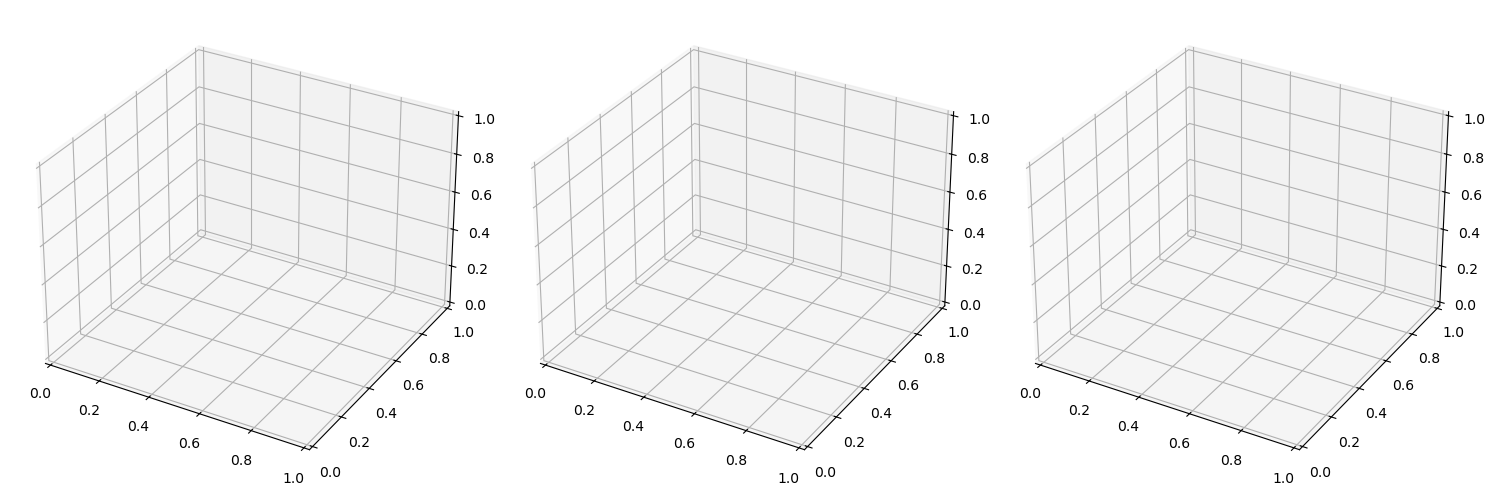

In [20]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

# First, let's collect all images and their depths into arrays
images = []
depths = []

for filepath in sorted_files:
    depth = float(re.findall(r"(\d+\.?\d*)", os.path.basename(filepath))[0])
    img = io.imread(filepath)
    img_normalized = img.astype(float) / 255.0
    images.append(img_normalized)
    depths.append(depth)

# Convert to numpy arrays
images = np.array(images)
depths = np.array(depths)

# Create a finer depth sampling
num_interpolated_slices = 50
depths_interpolated = np.linspace(depths.min(), depths.max(), num_interpolated_slices)

# Get dimensions
height, width = images[0].shape[:2]
num_channels = images[0].shape[2] if len(images[0].shape) == 3 else 1

# Create interpolated volume
interpolated_images = np.zeros((num_interpolated_slices, height, width, 3))

# Interpolate each pixel and channel across depths
for i in range(height):
    for j in range(width):
        if num_channels == 1:
            # For grayscale images, repeat the value for RGB
            pixel_values = images[:, i, j]
            for c in range(3):
                interpolated_images[:, i, j, c] = np.interp(depths_interpolated, depths, pixel_values)
        else:
            # For RGB images
            for c in range(3):
                pixel_values = images[:, i, j, c]
                interpolated_images[:, i, j, c] = np.interp(depths_interpolated, depths, pixel_values)

# Create figure
fig = plt.figure(figsize=(15, 5))

# Create subplots
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

def update(frame):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    
    # Set labels
    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
    
    stride = 10  # Increase stride for better performance
    
    # Calculate slice positions based on frame
    x_pos = int((width - 1) * frame / 99)  # -1 to avoid index error
    y_pos = int((height - 1) * frame / 99)
    z_pos = int((num_interpolated_slices - 1) * frame / 99)
    
    # X slice
    Y, Z = np.meshgrid(np.arange(0, height, stride), depths_interpolated)
    X = np.full_like(Y, x_pos)
    colors = interpolated_images[:, ::stride, x_pos]
    ax1.plot_surface(X, Y, Z, facecolors=colors, shade=False)
    ax1.set_title(f'X Slice at position {x_pos}')
    
    # Y slice
    X, Z = np.meshgrid(np.arange(0, width, stride), depths_interpolated)
    Y = np.full_like(X, y_pos)
    colors = interpolated_images[:, y_pos, ::stride]
    ax2.plot_surface(X, Y, Z, facecolors=colors, shade=False)
    ax2.set_title(f'Y Slice at position {y_pos}')
    
    # Z slice
    X, Y = np.meshgrid(np.arange(0, width, stride), np.arange(0, height, stride))
    Z = np.full_like(X, depths_interpolated[z_pos])
    colors = interpolated_images[z_pos, ::stride, ::stride]
    ax3.plot_surface(X, Y, Z, facecolors=colors, shade=False)
    ax3.set_title(f'Z Slice at position {z_pos}')
    
    # Set consistent view angles
    for ax in [ax1, ax2, ax3]:
        ax.view_init(elev=80, azim=60)
        ax.set_box_aspect([1, 1, 1])  # Make the plot cubic

# Create animation
anim = FuncAnimation(
    fig, 
    update, 
    frames=100, 
    interval=100,  # 100ms between frames
    blit=False
)

plt.tight_layout()
plt.show()


anim.save('afm_slices_3.gif', writer='pillow')


Interpolating slices...


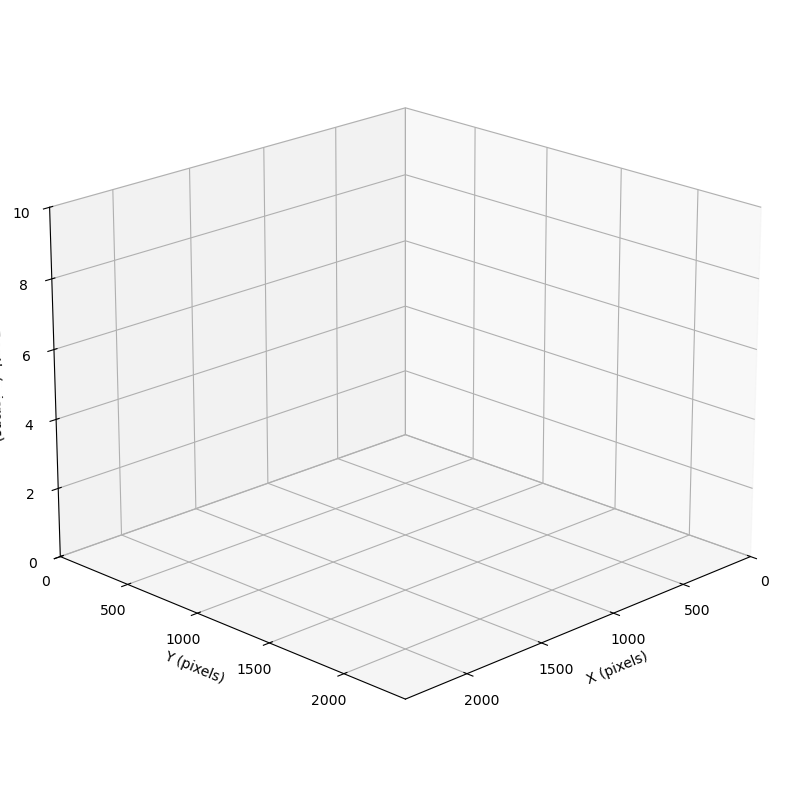

KeyboardInterrupt: 

In [21]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

# First, let's collect all images and their depths into arrays
images = []
depths = []

for filepath in sorted_files:
    depth = float(re.findall(r"(\d+\.?\d*)", os.path.basename(filepath))[0])
    img = io.imread(filepath)
    img_normalized = img.astype(float) / 255.0
    images.append(img_normalized)
    depths.append(depth)

# Convert to numpy arrays and invert the depth order
images = np.array(images)[::-1]  # Reverse the order of images
depths = np.array(depths)[::-1]  # Reverse the order of depths

# Create a finer depth sampling (inverted)
num_interpolated_slices = 200  # Increased for smoother visualization
depths_interpolated = np.linspace(depths.max(), depths.min(), num_interpolated_slices)  # Note max to min

# Get dimensions
height, width = images[0].shape[:2]
num_channels = images[0].shape[2] if len(images[0].shape) == 3 else 1

# Create interpolated volume
interpolated_images = np.zeros((num_interpolated_slices, height, width, 3))

# Interpolate each pixel and channel across depths
print("Interpolating slices...")
for i in range(height):
    for j in range(width):
        if num_channels == 1:
            # For grayscale images, repeat the value for RGB
            pixel_values = images[:, i, j]
            for c in range(3):
                interpolated_images[:, i, j, c] = np.interp(depths_interpolated, depths, pixel_values)
        else:
            # For RGB images
            for c in range(3):
                pixel_values = images[:, i, j, c]
                interpolated_images[:, i, j, c] = np.interp(depths_interpolated, depths, pixel_values)

# Create figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Set fixed view angles
ax.view_init(elev=20, azim=45)

# Set axis labels
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
ax.set_zlabel('Depth (microns)')

# Set axis limits
ax.set_xlim(0, width)
ax.set_ylim(0, height)
ax.set_zlim(depths_interpolated.min(), depths_interpolated.max())

def update(frame):
    ax.clear()
    
    # Reset view and labels (since clear removes them)
    ax.view_init(elev=20, azim=45)
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')
    ax.set_zlabel('Depth (microns)')
    ax.set_title(f'AFM Reconstruction (0 to {frame/num_interpolated_slices*depths.max():.1f} microns)')
    
    # Reset axis limits
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    ax.set_zlim(depths_interpolated.min(), depths_interpolated.max())
    
    stride = 3  # Small stride for high density
    
    # Plot all slices up to current frame
    for i in range(frame):
        Z = depths_interpolated[i]
        X, Y = np.meshgrid(np.arange(0, width, stride), np.arange(0, height, stride))
        colors = interpolated_images[i, ::stride, ::stride]
        ax.plot_surface(X, Y, np.full_like(X, Z), 
                       facecolors=colors,
                       shade=False,
                       alpha=0.9)  # Slight transparency to see structure

# Create animation
anim = FuncAnimation(
    fig, 
    update, 
    frames=num_interpolated_slices,
    interval=50,  # 50ms between frames
    blit=False
)

plt.tight_layout()
plt.show()

# Save animation
anim.save('afm_reconstruction.gif', writer='pillow', fps=20)

GPa intensity range: (np.uint8(0), np.uint8(255))


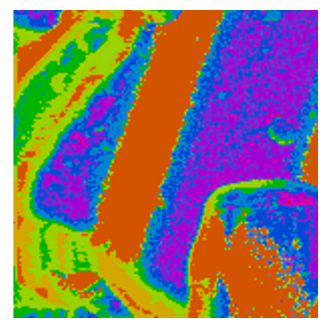

In [50]:
# We'll use the existing variable "img" and the provided "prepare_image" function
def prepare_image(image, crop_right=1500):
    """
    Crop out the embedded colorbar from the right side of the image and then extract a central square.
    First, removes crop_right columns from the right, then crops a square from the center of the remaining image.
    """
    if image.shape[1] <= crop_right:
        raise ValueError("crop_right is larger than the image width")
        
    # Remove the embedded colorbar
    cropped = image[:, :image.shape[1] - crop_right]
    
    # Determine the size of the square (using the smaller dimension)
    square_size = min(cropped.shape[0], cropped.shape[1])
    
    # Compute center indices
    center_y = cropped.shape[0] // 2
    center_x = cropped.shape[1] // 2
    half_size = square_size // 2
    
    # Crop the center square
    square_crop = cropped[center_y - half_size:center_y + half_size, center_x - half_size:center_x + half_size]
    return square_crop

# Crop the image to remove the embedded colorbar (default cropped out columns from the right).
cropped_img = prepare_image(img)

# Extract the range of intensities (interpreted here as the modulus in GPa)
gpa_range = (cropped_img.min(), cropped_img.max())
print("GPa intensity range:", gpa_range)

# Let's visualize the cropped image and its intensity histogram
plt.figure(figsize=(8, 4))
plt.imshow(cropped_img, cmap='gray')
# plt.title(f"Cropped Image\nGPa Intensity Range: {gpa_range}")
plt.axis('off')
plt.show()

# plt.figure(figsize=(8, 4))
# plt.hist(cropped_img.ravel(), bins=256, color='gray')
# plt.title("Histogram of GPa Intensities")
# plt.xlabel("Intensity (GPa)")
# plt.ylabel("Frequency")
# plt.show()

In [51]:
# Loop over each image in the file_list to load, crop, and compute the intensity range in GPa
intensity_ranges = {}

for file in file_list:
    try:
        # Read the image (assumes grayscale or color, but we'll use it as provided)
        image_data = io.imread(file)
        # Crop the image to remove the embedded colorbar
        cropped = prepare_image(image_data)
        # Compute the intensity range
        intensity_ranges[file] = (cropped.min(), cropped.max())
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Display the intensity range for each image
for file, gpa_range in intensity_ranges.items():
    print(f"{file}: GPa intensity range: {gpa_range}")

data/Holography-5-micron.png: GPa intensity range: (np.uint8(0), np.uint8(255))
data/Holography-10.png: GPa intensity range: (np.uint8(0), np.uint8(255))
data/Holography-3.png: GPa intensity range: (np.uint8(0), np.uint8(255))
data/Holograohy-1.png: GPa intensity range: (np.uint8(0), np.uint8(255))


Tomography stack shape: (4, 2350, 2350, 3)


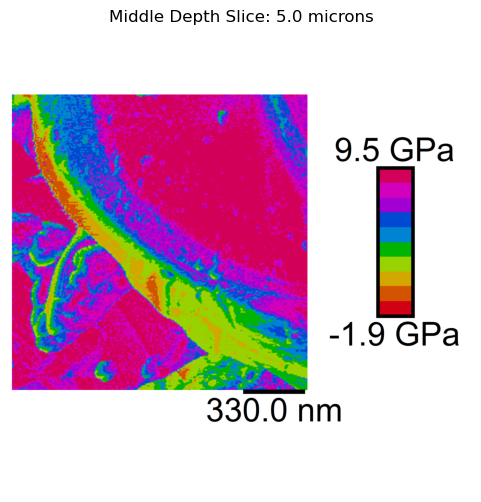

In [53]:
# Stack the images as a tomography depth reconstruction.
tomography_images = []
tomography_depths = []

# Loop through all files in file_list.
for f in file_list:
    try:
        # Parse depth from the filename using the provided function.
        depth = parse_depth_from_filename(os.path.basename(f))
    except Exception as e:
        print(f"Error parsing depth from {f}: {e}")
        continue

    try:
        # Read the image.
        img_temp = io.imread(f)
        # Crop the image using a crop_right value suitable for tomography.
        cropped_img_temp = prepare_image(img_temp, crop_right=50)
    except Exception as e:
        print(f"Error processing image {f}: {e}")
        continue

    tomography_images.append(cropped_img_temp)
    tomography_depths.append(depth)

if tomography_images:
    # Convert depths to a numpy array and sort the slices by depth.
    tomography_depths = np.array(tomography_depths)
    sort_idx = np.argsort(tomography_depths)
    tomography_images = [tomography_images[i] for i in sort_idx]
    sorted_depths = tomography_depths[sort_idx]
    
    # Stack the cropped images along a new depth axis.
    tomo_stack = np.stack(tomography_images)
    print("Tomography stack shape:", tomo_stack.shape)

    # Visualize a middle slice of the stack.
    mid_idx = len(tomography_images) // 2
    plt.figure(figsize=(6, 6))
    plt.imshow(tomo_stack[mid_idx])
    plt.title(f"Middle Depth Slice: {sorted_depths[mid_idx]} microns")
    plt.axis('off')
    plt.show()
else:
    print("No valid tomography images loaded.")

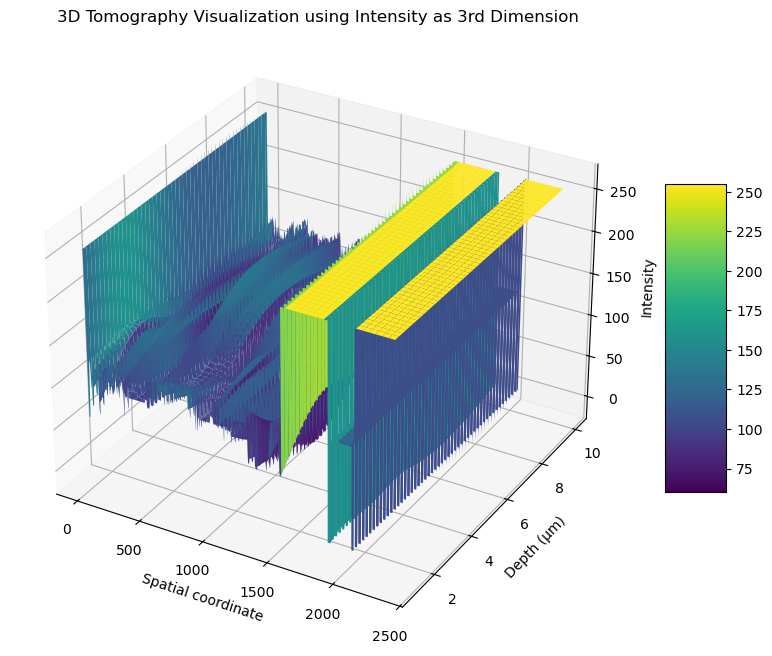

In [56]:
from scipy.interpolate import griddata

# Build the 1D profile for each slice using the central row.
# If the slice is RGB, average along the color channel.
profiles = []
for slice_img in tomo_stack:
    if slice_img.ndim == 3 and slice_img.shape[2] == 3:
        # convert to grayscale by averaging the channels
        slice_gray = np.mean(slice_img, axis=2)
    else:
        slice_gray = slice_img
    profile = slice_gray[H // 2, :]  # use the central row
    profiles.append(profile)
profiles = np.array(profiles)  # shape: (n_slices, W)

# Set up grid: points from the original (depth, x) pairs
n_slices = profiles.shape[0]
x_vals = np.arange(W)
# our original grid points: (d, x)
orig_depths = sorted_depths  # already sorted depths corresponding to each profile
points = np.array([(d, x) for d in orig_depths for x in x_vals])
values = profiles.flatten()

# Create a dense grid that spans the full depth range and spatial range
interp_depths = np.linspace(orig_depths.min(), orig_depths.max(), 100)
X_dense, D_dense = np.meshgrid(x_vals, interp_depths)
# Interpolate intensity values on the new grid
profiles_interp = griddata(points, values, (D_dense, X_dense), method='cubic')

# Plot: x coordinate vs depth vs intensity
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X_dense, D_dense, profiles_interp, cmap='viridis', edgecolor='none')
ax.set_xlabel("Spatial coordinate")
ax.set_ylabel("Depth (µm)")
ax.set_zlabel("Intensity")
ax.set_title("3D Tomography Visualization using Intensity as 3rd Dimension")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [36]:
def parse_depth_from_filename(filename):
    """
    Extract depth information from the filename.
    Updated to support optional units like 'um', 'micron', or 'microns'.
    """
    match = re.search(r'(\d+)\s*(?:um|micron(?:s)?)?', filename, re.IGNORECASE)
    if match:
        return float(match.group(1))
    else:
        raise ValueError(f"Could not parse depth from filename: {filename}")

def load_depth_profiles(data_dir, file_pattern="*spm.png", crop_right=50):
    """
    Loads AFM profiles from images in the data directory.
    Crops each image to remove the embedded colorbar, then extracts the central row as the 1D profile
    and associates it with the depth parsed from the filename.
    Returns:
        sorted_depths: list of depths (in microns) sorted in ascending order.
        profiles: 2D numpy array (rows: depth slices, columns: spatial coordinate)
    """
    file_list = sorted(glob.glob(os.path.join(data_dir, file_pattern)))
    if not file_list:
        raise ValueError(f"No files found in {data_dir} with pattern {file_pattern}")

    depth_profiles = []
    depths = []
    for filepath in file_list:
        try:
            depth = parse_depth_from_filename(os.path.basename(filepath))
        except ValueError as e:
            print(e)
            continue

        # Read the image; assuming it is a grayscale image.
        img = io.imread(filepath, as_gray=True)

        # Crop the image to remove the embedded colorbar
        try:
            img_cropped = prepare_image(img, crop_right=crop_right)
        except ValueError as e:
            print(e)
            continue

        # Extract the central row as the 1D profile
        profile = img_cropped[img_cropped.shape[0] // 2, :]
        depths.append(depth)
        depth_profiles.append(profile)

    depths = np.array(depths)
    #Enforce uniform profile lengths
    if len(depth_profiles) > 0:
        min_length = min(len(p) for p in depth_profiles)
        depth_profiles = np.array([p[:min_length] for p in depth_profiles])
    else:
        depth_profiles = np.array([])
    sort_idx = np.argsort(depths)
    sorted_depths = depths[sort_idx]
    return sorted_depths, depth_profiles[sort_idx, :]


Loaded depths (microns): [ 1.  3.  5. 10.]


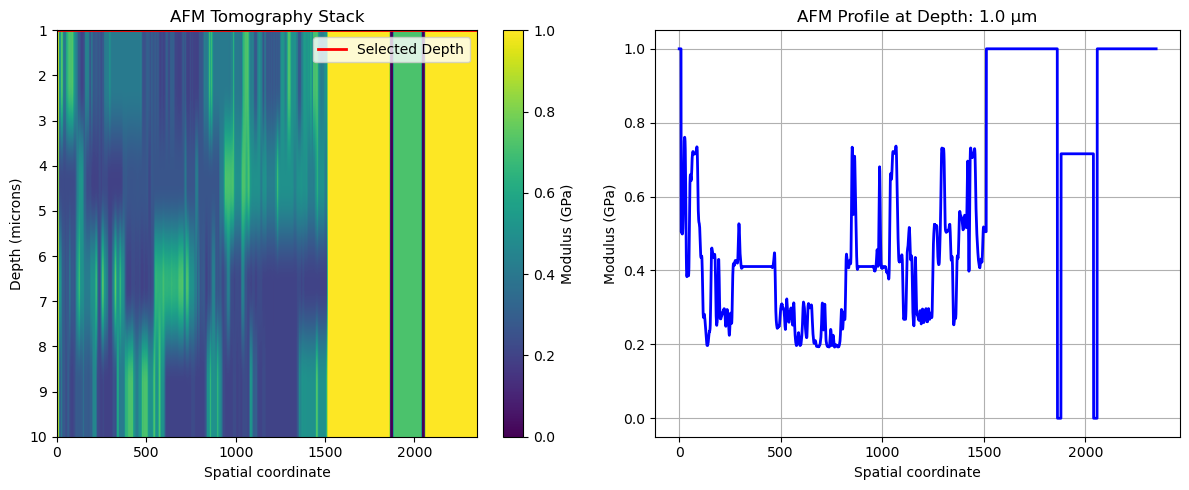

Output()

In [ ]:
from IPython.display import display

def dynamic_visualization(depths, profiles):
    # Create a figure with two subplots
    fig, (ax_stack, ax_profile) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the complete stack
    im = ax_stack.imshow(profiles, aspect='auto', cmap='viridis', 
                           extent=[0, profiles.shape[1]-1, depths[-1], depths[0]])
    ax_stack.set_xlabel("Spatial coordinate")
    ax_stack.set_ylabel("Depth (microns)")
    ax_stack.set_title("AFM Tomography Stack")
    fig.colorbar(im, ax=ax_stack, label="Modulus (GPa)")

    # Initialize horizontal marker and initial 1D profile
    current_line = ax_stack.axhline(depths[0], color='red', linewidth=2, label="Selected Depth")
    ax_stack.legend()
    current_profile, = ax_profile.plot(profiles[0, :], color='blue', linewidth=2)
    ax_profile.set_xlabel("Spatial coordinate")
    ax_profile.set_ylabel("Modulus (GPa)")
    ax_profile.set_title(f"AFM Profile at Depth: {depths[0]:.1f} µm")
    ax_profile.grid(True)

    plt.tight_layout()

    def update_slice(slice_index):
        selected_depth = depths[slice_index]
        current_line.set_ydata(selected_depth)
        current_profile.set_ydata(profiles[slice_index, :])
        ax_profile.set_title(f"AFM Profile at Depth: {selected_depth:.1f} µm")
        fig.canvas.draw_idle()

    # Create interactive slider
    slider = widgets.IntSlider(value=0, min=0, max=profiles.shape[0]-1, step=1,
                                description='Depth Slice', continuous_update=True)
    ui = widgets.VBox([slider])
    out = widgets.interactive_output(update_slice, {'slice_index': slider})

    display(ui, out)
    return fig

def main(crop_right=50):
    data_dir = os.path.join("data")
    try:
        depths, profiles = load_depth_profiles(data_dir, file_pattern="*.png", crop_right=crop_right)
    except ValueError as e:
        print(e)
        return

    print("Loaded depths (microns):", depths)
    dynamic_visualization(depths, profiles)

# Execute main to launch the interactive visualization
main()